In [1]:
import tensorflow as tf 
#import CNN layers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential, load_model
#import adam optimizer for training
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
#import ImageDataGenerator for augmenation of data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import OpenCV to handle image operations such as reading, resizing & reshaping
import cv2
#import numpy for linear algebra operations
import numpy as np
#import pandas library for data processing operations I/O in CSV file
import pandas as pd
from tqdm import tqdm
import os
from random import shuffle
from time import time
#import ZipFile to access contents of a zip folder
from zipfile import ZipFile as zf


In [2]:
#Read and extract training and testing data
from zipfile import ZipFile as zf
train_zip = zf('train.zip', 'r')
train_zip.extractall()
train_zip.close()
test_zip = zf('test1.zip', 'r')
test_zip.extractall()
test_zip.close()

In [3]:
IMG_SIZE = 50
LR = 0.0003 #learning rate
BATCH_SIZE = 32


In [4]:
MODEL_NAME = 'dog_cat_classifier.h5'.format(LR,'CovNet-128(2)-64(2)-32(2)-512-128-1')
MODEL_PATH = os.path.join('saved_models',MODEL_NAME)

In [5]:
#Training and testing data directory
TRAIN_DIR = './train/'
TEST_DIR = './test1/'

In [6]:
#Function to get label for an image
def get_label(img):
    category = img.split('.')[0]
    if category == 'cat':
        return [0]
    else :
        return [1]



In [7]:
#Forming training data from train.zip
training_data = []
for img in tqdm(os.listdir(TRAIN_DIR)):
    label = get_label(img)
    path = os.path.join(TRAIN_DIR,img)
    img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
    img = img/255
    training_data.append([np.array(img),np.array(label)])
shuffle(training_data)
np.save('training_data_{}.npy'.format(IMG_SIZE),training_data)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [04:33<00:00, 91.50it/s]
c:\users\aadarsh gupta\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [8]:
#Forming testing data from test1.zip
testing_data = []
for img in tqdm(os.listdir(TEST_DIR)):
    img_id = int(img.split('.')[0])
    path = os.path.join(TEST_DIR,img)
    img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
    img = img/255
    testing_data.append([np.array(img),img_id])
testing_data.sort(key = lambda x: x[1])
np.save('testing_data_{}.npy'.format(IMG_SIZE),testing_data)
        

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [02:14<00:00, 93.06it/s]


In [9]:
#Bifurcate training data to 1) Train dataset  2) Validation dataset
partition = 1000
train = training_data[:-partition]    
test= training_data[-partition:]      


X_train = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y_train = np.array([i[1] for i in train])

X_val = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y_val = np.array([i[1] for i in test])

print(np.shape(X_train))
print(np.shape(Y_train))
print(np.shape(X_val))
print(np.shape(Y_val))

(24000, 50, 50, 1)
(24000, 1)
(1000, 50, 50, 1)
(1000, 1)


In [10]:
#Image Data Augmentation
datagen = ImageDataGenerator(rotation_range=20,width_shift_range=0.05,height_shift_range=0.05,
                            zoom_range=0.05,horizontal_flip=True,vertical_flip=True)


datagen.fit(X_train)

In [11]:
#Normalization : normaized data not used here
X_train_normal = X_train / 255 
X_val_normal = X_val / 255
print(np.shape(X_train_normal))
print(np.shape(X_val_normal))

(24000, 50, 50, 1)
(1000, 50, 50, 1)


In [12]:
#Forming CNN Architecture
model = Sequential()
dr_rate = 0.35

    # 1st Block
model.add(Conv2D(input_shape=(IMG_SIZE, IMG_SIZE, 1),filters=128, kernel_size=5, strides=1,padding='same'))
model.add(Conv2D(filters=128, kernel_size=5, strides=1,padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))



    # 2nd Block
model.add(Conv2D(filters=64, kernel_size=5, strides=1,padding='same'))
model.add(Conv2D(filters=64, kernel_size=5, strides=1,padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    
    # 3rd Block
model.add(Conv2D(filters=32, kernel_size=5, strides=1,padding='same'))
model.add(Conv2D(filters=32, kernel_size=5, strides=1,padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))


    # 4th Block - FC Block

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(dr_rate))
model.add(Dense(128, activation='relu'))
model.add(Dropout(dr_rate))
model.add(Dense(1, activation='sigmoid'))



In [13]:
#Model summary to visualize tabular form
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 128)       3328      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 128)       409728    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        204864    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 32)        5

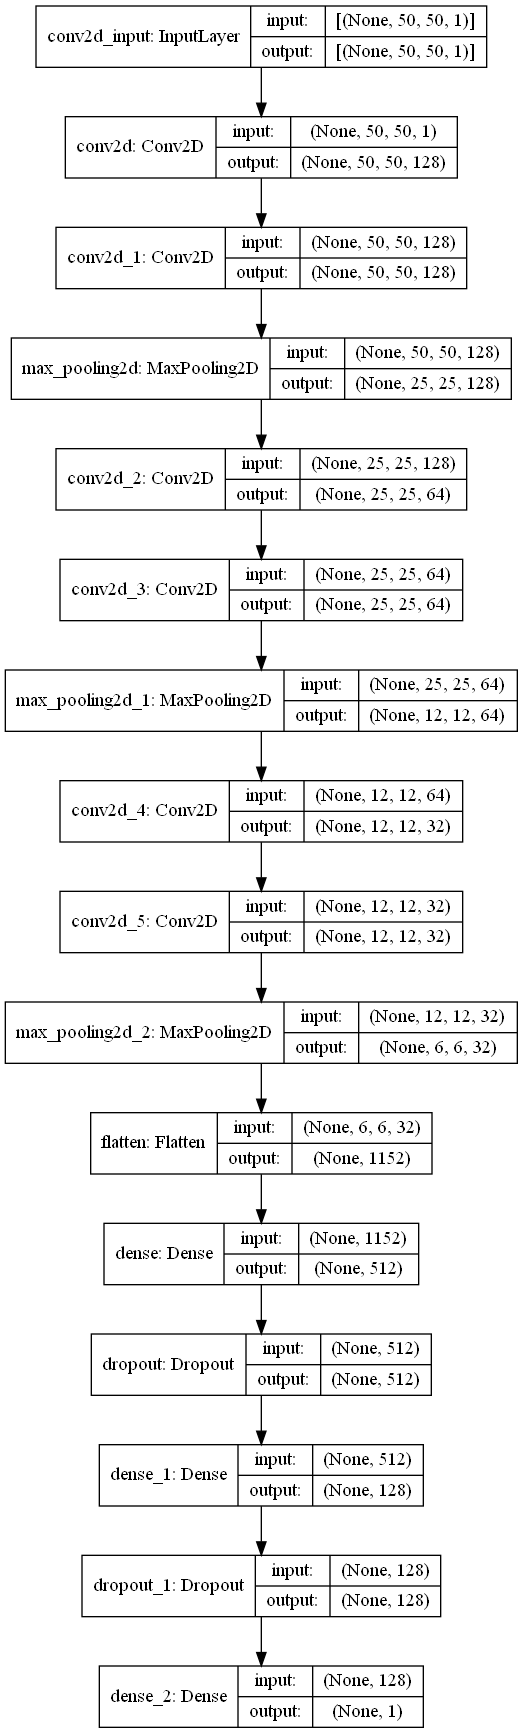

In [14]:
# Layer by layer information of the model
tf.keras.utils.plot_model( 
    model,
    show_shapes=True,
    show_layer_names=True, 
)

In [15]:
adam_optimizer = Adam(learning_rate=0.0003)
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3,patience=3,verbose=1,
                              mode='max', min_lr=0.000001)
early_stop = EarlyStopping(monitor='val_loss',patience=3,verbose=1,mode='min')
model_checkpoint = ModelCheckpoint(filepath=MODEL_PATH,monitor='val_accuracy',verbose=1,save_best_only=True, mode='max')



In [16]:
model.compile(
    optimizer=adam_optimizer, 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

In [32]:

training_history = model.fit( 
    X_train,
    Y_train,
    epochs=30, 
    validation_data=(X_val, Y_val), verbose =2, 
    callbacks=[tensorboard,reduce_lr,early_stop,model_checkpoint])

Epoch 1/30
750/750 - 946s - loss: 0.5833 - accuracy: 0.6922 - val_loss: 0.5112 - val_accuracy: 0.7430

Epoch 00001: val_accuracy improved from -inf to 0.74300, saving model to saved_models\dog_cat_classifier.h5
Epoch 2/30
750/750 - 909s - loss: 0.5070 - accuracy: 0.7558 - val_loss: 0.4782 - val_accuracy: 0.7750

Epoch 00002: val_accuracy improved from 0.74300 to 0.77500, saving model to saved_models\dog_cat_classifier.h5
Epoch 3/30
750/750 - 912s - loss: 0.4559 - accuracy: 0.7864 - val_loss: 0.4644 - val_accuracy: 0.7760

Epoch 00003: val_accuracy improved from 0.77500 to 0.77600, saving model to saved_models\dog_cat_classifier.h5
Epoch 4/30
750/750 - 913s - loss: 0.4144 - accuracy: 0.8079 - val_loss: 0.4567 - val_accuracy: 0.7860

Epoch 00004: val_accuracy improved from 0.77600 to 0.78600, saving model to saved_models\dog_cat_classifier.h5
Epoch 5/30
750/750 - 911s - loss: 0.3650 - accuracy: 0.8357 - val_loss: 0.4368 - val_accuracy: 0.7940

Epoch 00005: val_accuracy improved from 0.78

In [33]:
#Predicting labels for testing data
X_test = np.array([i[0] for i in testing_data]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
ids = [i[1] for i in testing_data]
pred = model.predict(X_test)

In [51]:
import math
def sigmoid(x):
    z = 1/(1+np.exp(-x))
    return z
def roundoff(x):
    if x<0.5:
        return 0
    else:
        return 1

print(len(pred))
print(pred)

12500
[[0.97001433]
 [0.99997795]
 [0.9233942 ]
 ...
 [0.970894  ]
 [0.96624506]
 [0.00110841]]


In [78]:
output = [0]*len(pred)


df=pd.read_csv('sampleSubmission.csv', sep=',',header=None)
ans_data = df.values
print(np.shape(ans_data))
print(ans_data[2][1])
print(len(pred))


(12501, 2)
0
12500


In [94]:
#Evaluarting number of data points correctly classified
count = 0
i = 0
while (i<len(pred)):
    output[i] = roundoff(pred[i][0])
    if int(ans_data[i+1][1]) == output[i]:
        count = count+1
        i = i+1    
    else:
        i = i+1
print(100*count/len(pred))


46.6
